In [1]:
import math
import numpy
from scipy import integrate
from matplotlib import pyplot
%matplotlib inline

### <i>P1: Coefficient of pressure for flow past cylinder</i>

In [2]:
class Panel:
    def __init__(self, xa, ya, xb, yb, sigma):
        #Start and end points
        self.xa, self.xb = xa, xb
        self.ya, self.yb = ya, yb
        
        #Center and length
        self.xc, self.yc = 0.5*(xa+xb), 0.5*(ya+yb)
        self.length = math.sqrt((xb-xa)**2 + (yb-ya)**2)
        
        #Panel strength
        self.strength = sigma
        
        #Define panel orientation
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa > 0.:    
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
        #self.beta = math.atan2((yb-ya), (xb-xa))
            
        #Define normal vectors
        self.normx = yb-ya
        self.normy = xa-xb
        
        #Define tangent vectors
        self.tanx = xb-xa
        self.tany = yb-ya
            
        self.sigma = sigma
        self.vn = 0.
        self.vt = 0.
        self.cp = 0.

In [3]:
def get_source_panel_velocity(Xg, Yg, p):
    
    x_p =  math.sin(p.beta)*(Xg-p.xb) - math.cos(p.beta)*(Yg-p.yb)
    y_p =  math.cos(p.beta)*(Xg-p.xb) + math.sin(p.beta)*(Yg-p.yb)
    
    u_p = p.sigma/(4*math.pi)*numpy.log((x_p**2+y_p**2)/((x_p-p.length)**2+y_p**2))
    v_p = p.sigma/(2*math.pi)*(numpy.arctan2(y_p,x_p-p.length) - numpy.arctan2(y_p,x_p))
    
    u =  math.sin(p.beta)*u_p + math.cos(p.beta)*v_p
    v = -math.cos(p.beta)*u_p + math.sin(p.beta)*v_p
    
    return u, v

In [4]:
#Define geometry for circle:

R = 1.0
theta = numpy.linspace(0, 2.0*math.pi, 100)
xcyl, ycyl = R*numpy.cos(theta), R*numpy.sin(theta)

#Define number of panels:
N_panels = 30

# defining the end-points of the panels
xend = R*numpy.cos(numpy.linspace(0, 2*math.pi, N_panels+1))
yend = R*numpy.sin(numpy.linspace(0, 2*math.pi, N_panels+1))

#Strength of panels:
sigma = 1.0

#Define panels:
panels = numpy.empty(N_panels,dtype = object)
for i in range (N_panels):
    panels[i] = Panel(xend[i], yend[i], xend[i+1], yend[i+1], sigma)

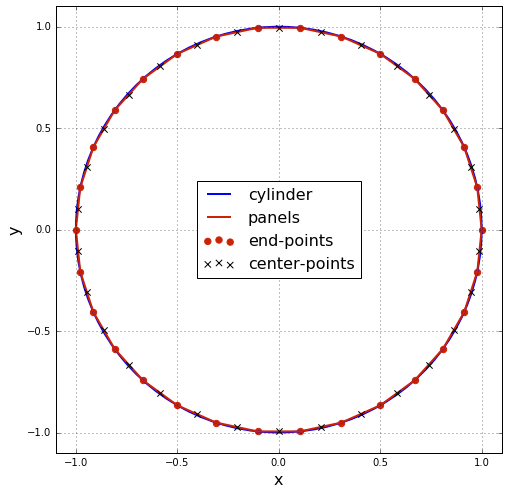

In [5]:
# plotting the panels
size = 8
pyplot.figure(figsize=(size, size))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(xcyl, ycyl, color='b', linestyle='-', linewidth=2)
pyplot.plot(xend, yend, color='#CD2305', linestyle='-', linewidth=2)
pyplot.scatter([p.xa for p in panels], [p.ya for p in panels], color='#CD2305', s=40)
pyplot.scatter([p.xc for p in panels], [p.yc for p in panels], color='k', marker='x',s=40, zorder=3)
pyplot.legend(['cylinder', 'panels', 'end-points', 'center-points'], 
           loc='best', prop={'size':16})
pyplot.xlim(-1.1, 1.1)
pyplot.ylim(-1.1, 1.1);

In [6]:
A = numpy.zeros((N_panels,N_panels)); b = numpy.zeros(N_panels); uinf = 1.0

for i in range (N_panels):
    panels[i].vn = 0.0
    xpi = panels[i].xc; ypi = panels[i].yc
    betap = panels[i].beta
    for j in range (N_panels):
        if (i != j):
            [up, vp]     = get_source_panel_velocity(xpi, ypi, panels[j])
            panels[i].vn = panels[i].vn + math.cos(betap)*(up) + math.sin(betap)*(vp)
            A[i,j]       = math.cos(betap)*(up) + math.sin(betap)*(vp)
        else:
            panels[i].vn = panels[i].vn + panels[i].sigma/2.0
            A[i,i] = panels[i].sigma/2.0
            
    b[i] = uinf*math.cos(betap)
    #print(xpi, ypi, b[i])
    
xsigma = numpy.linalg.solve(A,b)

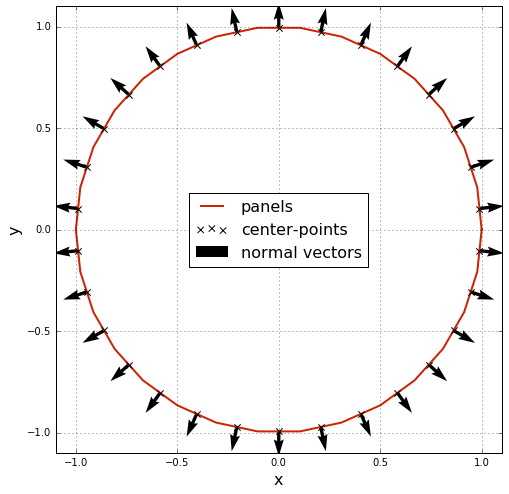

In [7]:
# plotting the panels
size = 8
pyplot.figure(figsize=(size, size))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(xend, yend, color='#CD2305', linestyle='-', linewidth=2)
pyplot.scatter([p.xc for p in panels], [p.yc for p in panels], color='k', marker='x',s=40, zorder=3)
pyplot.quiver([p.xc for p in panels], [p.yc for p in panels], \
[p.vn*math.cos(p.beta) for p in panels], [p.vn*math.sin(p.beta) for p in panels] )
pyplot.legend(['panels', 'center-points', 'normal vectors'], 
           loc='best', prop={'size':16})
pyplot.xlim(-1.1, 1.1)
pyplot.ylim(-1.1, 1.1);

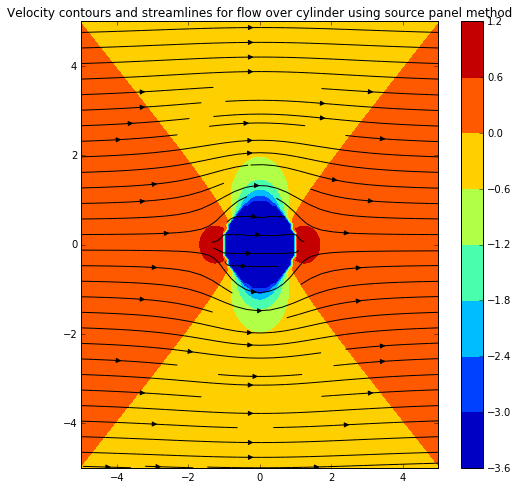

In [8]:
N = 100; uinf = 1.0
x = numpy.linspace(-5.0, 5.0, N); y = numpy.linspace(-5.0, 5.0, N)
X, Y = numpy.meshgrid(x,y)

xvel = numpy.zeros_like(X); yvel = numpy.zeros_like(X);

for ip in range(N_panels):
    panels[ip].sigma = -1.0*xsigma[ip]

for ip in range(N_panels):
    xp = panels[ip].xc; yp = panels[ip].yc; 
    for i in range (N):
        for j in range (N):
            [dxvel, dyvel] = get_source_panel_velocity(X[i,j], Y[i,j], panels[ip])
            xvel[i,j] = xvel[i,j] + dxvel; 
            yvel[i,j] = yvel[i,j] + dyvel;

xvel = xvel + uinf

pyplot.figure(figsize=(8,8))
pyplot.xlim(-5,5)
pyplot.ylim(-5,5)
pyplot.title('Velocity contours and streamlines for flow over cylinder using source panel method')
pyplot.contourf(X, Y, 1.0-(xvel**2 + yvel**2)/uinf**2)
#pyplot.contourf(X, Y, numpy.sqrt(xvel**2 + yvel**2))
pyplot.colorbar()
pyplot.streamplot(X, Y, xvel, yvel, color = '#000000')

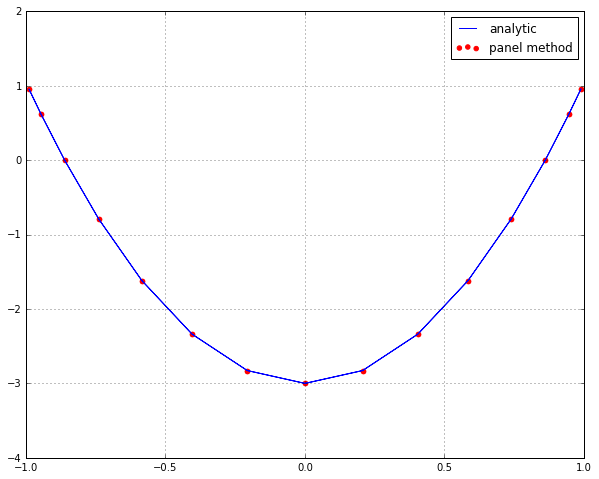

In [9]:
#Compare Cp from panel method to analytic

Cp_an = numpy.zeros(N_panels)
Cp_pm = numpy.zeros_like(Cp_an)
vtx   = numpy.zeros_like(Cp_an)
vty   = numpy.zeros_like(Cp_an)

for ip in range(N_panels):
    theta = math.atan2(panels[ip].yc,panels[ip].xc)
    Cp_an[ip] = 1.0-4.0*(numpy.sin(theta))**2
    
    for jp in range(N_panels):
        if (ip != jp):
            [velx_temp, vely_temp] = get_source_panel_velocity(panels[ip].xc,\
                                                panels[ip].yc, panels[jp])
        if (ip == jp):
            velx_temp = panels[ip].sigma/2.0*numpy.cos(panels[ip].beta)
            vely_temp = panels[ip].sigma/2.0*numpy.sin(panels[ip].beta)
        vtx[ip] += velx_temp; vty[ip] += vely_temp
            
    vtx[ip] = vtx[ip] + uinf
    Cp_pm[ip] = 1.0 - (vtx[ip]**2+vty[ip]**2)/uinf**2
        
pyplot.figure(figsize=(10,8))
pyplot.xlim(-1.0,1.0)
pyplot.ylim(-4.0,2.0)
pyplot.grid(True)
pyplot.plot([p.xc for p in panels], Cp_an)
pyplot.scatter([p.xc for p in panels], Cp_pm, color = '#FF0000')
#pyplot.scatter([p.xc for p in panels], numpy.sqrt(vtx**2+vty**2), color = '#FF0000')
pyplot.legend(['analytic', 'panel method'])

<hr>

### <i>P2: Coefficient of pressure for flow past NACA 0012</i>

In [10]:
def JoukowskiTransform(zetamat, zetac, a):
    zmat = (zetamat+zetac) + a**2/(zetamat+zetac)
    return zmat

In [11]:
#Define geometry for circle:

R = 1.0
theta = numpy.linspace(0, 2.0*math.pi, 100)
xcyl, ycyl = R*numpy.cos(theta), R*numpy.sin(theta)
alpha = 0.0;

#Define number of panels:
N_panels = 20

T = 0.12; H = 0.0; c = 1.0; a = c/4
ip = 0

zeta_c = -4*a/(3*math.sqrt(3))*T + 1j*2*a*H
r_s = (0.25 +T/(3*math.sqrt(3)))

# defining the end-points of the panels
xend = R*numpy.cos(numpy.linspace(0, 2*math.pi, N_panels+1))
yend = R*numpy.sin(numpy.linspace(0, 2*math.pi, N_panels+1))

#Define panels:
panels = numpy.empty(N_panels,dtype = object)
for i in range (N_panels):
    zeta1 = (xend[i] +1j*yend[i])*r_s
    zeta2 = (xend[i+1] +1j*yend[i+1])*r_s
    Z1 = JoukowskiTransform(zeta1, zeta_c, a)
    Z2 = JoukowskiTransform(zeta2, zeta_c, a)
    panels[i] = Panel(Z1.real, Z1.imag, Z2.real, Z2.imag, 1.)

In [12]:
A = numpy.zeros((N_panels,N_panels)); b = numpy.zeros(N_panels); uinf = 1.0

for i in range (N_panels):
    panels[i].vn = 0.0
    xpi = panels[i].xc; ypi = panels[i].yc
    betap = panels[i].beta
    for j in range (N_panels):
        if (i != j):
            [up, vp]     = get_source_panel_velocity(xpi, ypi, panels[j])
            panels[i].vn = panels[i].vn + math.cos(betap)*(up) + math.sin(betap)*(vp)
            A[i,j]       = math.cos(betap)*(up) + math.sin(betap)*(vp)
        else:
            panels[i].vn = panels[i].vn + panels[i].sigma/2.0
            A[i,i] = panels[i].sigma/2.0
            
    b[i] = uinf*math.cos(betap)
    #print(xpi, ypi, b[i])
    
xsigma = numpy.linalg.solve(A,b)

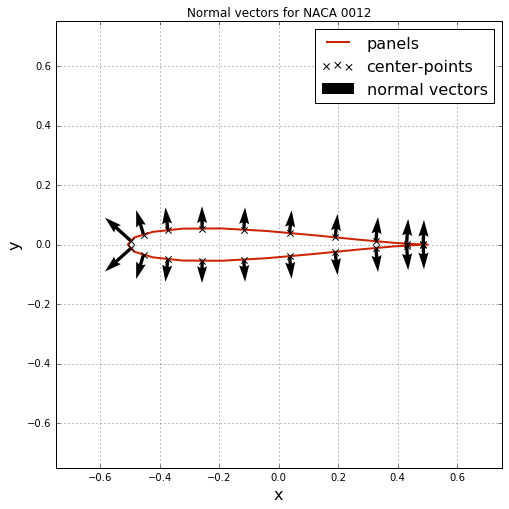

In [13]:
# plotting the panels
size = 8
pyplot.figure(figsize=(size, size))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.title('Normal vectors for NACA 0012')
pyplot.plot([p.xa for p in panels], [p.ya for p in panels], color='#CD2305', linestyle='-', linewidth=2)
pyplot.scatter([p.xc for p in panels], [p.yc for p in panels], color='k', marker='x',s=40, zorder=3)
pyplot.quiver([p.xc for p in panels], [p.yc for p in panels], \
[p.vn*math.cos(p.beta) for p in panels], [p.vn*math.sin(p.beta) for p in panels] )
pyplot.legend(['panels', 'center-points', 'normal vectors'], 
           loc='best', prop={'size':16})
pyplot.xlim(-0.75, 0.75);
pyplot.ylim(-0.75, 0.75);

In [14]:
N = 100;
x = numpy.linspace(-1.0, 1.0, N); y = numpy.linspace(-1.0, 1.0, N)
X, Y = numpy.meshgrid(x,y)

xvel = numpy.zeros_like(X); yvel = numpy.zeros_like(X);

for ip in range(N_panels):
    panels[ip].sigma = -1.0*xsigma[ip]

for ip in range(N_panels):
    xp = panels[ip].xc; yp = panels[ip].yc; 
    for i in range (N):
        for j in range (N):
            [dxvel, dyvel] = get_source_panel_velocity(X[i,j], Y[i,j], panels[ip])
            xvel[i,j] = xvel[i,j] + dxvel; 
            yvel[i,j] = yvel[i,j] + dyvel;

xvel = xvel + uinf

#Compare Cp from panel method to analytic

Cp_an = numpy.zeros(N_panels)
Cp_pm = numpy.zeros_like(Cp_an)
vtx   = numpy.zeros_like(Cp_an)
vty   = numpy.zeros_like(Cp_an)

for ip in range(N_panels):
    theta = math.atan2(panels[ip].yc,panels[ip].xc)
    #Cp_an[ip] = 1.0-4.0*(numpy.sin(theta))**2
    
    for jp in range(N_panels):
        if (ip != jp):
            [velx_temp, vely_temp] = get_source_panel_velocity(panels[ip].xc,\
                                                panels[ip].yc, panels[jp])
        if (ip == jp):
            velx_temp = panels[ip].sigma/2.0*numpy.cos(panels[ip].beta)
            vely_temp = panels[ip].sigma/2.0*numpy.sin(panels[ip].beta)
        vtx[ip] += velx_temp; vty[ip] += vely_temp
            
    vtx[ip] = vtx[ip] + uinf
    Cp_pm[ip] = 1.0 - (vtx[ip]**2+vty[ip]**2)/uinf**2

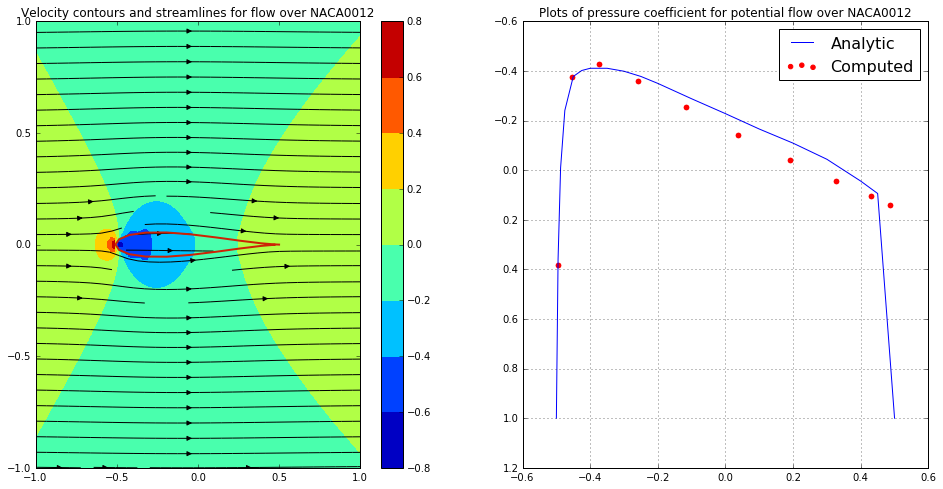

In [20]:
voverVsquared=numpy.array([0, 0.64, 1.01, 1.241, 1.378, 1.402, 1.411, 1.411, 1.399, 1.378, 1.35, 1.288, 1.228, 1.166, 1.109, 1.044, 0.956, 0.906, 0])
xtheo=numpy.array([0, 0.5, 1.25, 2.5, 5.0, 7.5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 95, 100])
xtheo = xtheo/100

xtheo -= 0.5
pyplot.figure(figsize=(16,8))

pyplot.subplot(121)
pyplot.xlim(-1,1)
pyplot.ylim(-1,1)
pyplot.title('Velocity contours and streamlines for flow over NACA0012')
pyplot.plot([p.xa for p in panels], [p.ya for p in panels], \
            color='#CD2305', linestyle='-', linewidth=2)
pyplot.contourf(X, Y, 1.0-(xvel**2 + yvel**2)/uinf**2)
pyplot.colorbar()
pyplot.streamplot(X, Y, xvel, yvel, color = '#000000')

pyplot.subplot(122)
pyplot.grid(True)
pyplot.ylim(1.2,-0.6)
pyplot.title('Plots of pressure coefficient for potential flow over NACA0012')
pyplot.plot(xtheo,1.0- voverVsquared)
pyplot.scatter([p.xc for p in panels], Cp_pm, color = '#FF0000')
pyplot.legend(['Analytic','Computed'], loc='best', prop={'size':16})

<hr>

### <i>P3: Flux through the panels</i>

In [25]:
pflux = 0.0;
for ip in range (N_panels):
    psigma = panels[ip].sigma;
    plen = numpy.sqrt((panels[ip].xb-panels[ip].xa)**2 + (panels[ip].yb-panels[ip].ya)**2)
    #print('psigma',psigma,'plen',plen)
    pflux += psigma*plen
    
print('Sum of panelwise flux = ',pflux)

Sum of panelwise flux =  0.00934863628609


The sum of the panelwise fluxes, integrated over the surface of the airfoil is $\approx 0.0093486$. Ideally, this value should be zero. For the panel approximation to be a valid estimate of potential flow over an airfoil, the control volume must not generate any mass, other than the flux of the freestream at the control volume boundaries. 

This is also a consequence of solving the simultaneous system of equations with the constraint of no net normal velocity, when flow from the panels is superimposed with the freestream. 